In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0-preview is required
import tensorflow
assert tensorflow.__version__ >= "2.0"

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,BatchNormalization,InputLayer,Layer,Conv2D,MaxPooling2D,Dense,Dropout,Activation,Flatten,Lambda,Reshape,Concatenate,concatenate

from tensorflow.keras import backend as K

import pypianoroll
from pypianoroll import Multitrack, Track

In [2]:
def toPypianoroll(created_music, music_index, pypianoroll_musics):
    music = pypianoroll_musics[music_index]
    tempo = music.tempo[0:10]
    downbeat = music.downbeat[0:10]
    beat_resolution = music.beat_resolution
    name = music.name
    
    Baixo = np.zeros((960,36))
    Cima = np.zeros((960,44))
    
    print(Cima.shape)
    print(created_music.shape)
    print(Baixo.shape)
    
    music_array = np.concatenate((Baixo,created_music,Cima),axis=1)
    
    pypianoroll_music = Track(pianoroll = music_array, program=0, is_drum=False,
              name='Guitar')
    
    return Multitrack(tracks = [pypianoroll_music], tempo = tempo, downbeat = downbeat,
        beat_resolution = beat_resolution, name = name)

In [3]:
def formatSongs(musics):
    for m in musics:
        m.pianoroll = np.array(m.pianoroll[384:1344,:]) # faixa de steps para Nº compassos == 10

In [4]:
def rounded_accuracy(y_true, y_pred):
    return tensorflow.keras.metrics.binary_accuracy(tensorflow.round(y_true), tensorflow.round(y_pred))

In [5]:
class DenseTied(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.activity_regularizer = activity_regularizer
        self.kernel_constraint = kernel_constraint
        self.bias_constraint = bias_constraint
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1] == self.units
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = Activation(self.activation)(output)
        return output


In [6]:
music_files = []

for root, subFolders, files in os.walk(os.path.realpath("D:\Insper\9o Semestre\Machine Learning\Projeto Musica\Extraida\lpd_5")):
    if files:
        music_files.append(root + "/" + files[0])

In [7]:
_range = 2500
pypianoroll_musics = []

for music in music_files[:_range]:
    pypianoroll_musics.append(pypianoroll.load(music))

In [8]:
guitar_tracks = []
tempo_song = [] # to rebuild midi file, with Multitrack API from Pypianoroll

for music in pypianoroll_musics:
    for track in music.tracks:
        if track.name == 'Guitar':
            if len(track.pianoroll) > 0: 
                guitar_tracks.append(track) 
                tempo_song.append(music.tempo)
                
formatSongs(guitar_tracks)

In [9]:
compasses_array = []
for track in guitar_tracks:
    Tamanho_diferente=0
    music = track.pianoroll
    compass_array = []
    for compass in range(10):
        left_limit = 96 * compass
        right_limit = 96 + 96 * compass
        if (len(music[left_limit : right_limit])==96):
            compass_array.append(music[left_limit : right_limit])
        if (len(music[left_limit : right_limit])<96):
            Tamanho_diferente+=1
    if (Tamanho_diferente==0):       
        compasses_array.append(compass_array)
print(len(guitar_tracks))
print(len(compasses_array))
print(Tamanho_diferente)

1707
1706
0


In [10]:
guitar_tracks[0].pianoroll.shape

(960, 128)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(compasses_array, compasses_array, test_size=0.1, random_state=42)


In [12]:
Compasses_array = np.array(compasses_array)
print (Compasses_array.shape)

compasses_array = Compasses_array[:,:,:,37:85]
print (compasses_array.shape)

(1706, 10, 96, 128)
(1706, 10, 96, 48)


In [13]:
Compassos=[]
Entrada = Input(shape=(10,96,48))
#Densa_Inicial =  Dense(10,kernel_regularizer=tensorflow.keras.regularizers.l2(0.01))
for k in range(10):
    Entrada_Crop = Lambda(lambda x: x[:,k,:,:])(Entrada)
    Flat = Flatten()(Entrada_Crop)
    Densa = Dense(100)(Flat)
    #Batch_1 = BatchNormalization(momentum=0.7)(Densa)
    Act_1 = Activation('selu')(Densa)
    Drop_1 = Dropout(0.3)(Act_1)
    Compassos.append(Drop_1) 

Conc = Concatenate()(Compassos)

Densa_Meio  = Dense(100)

Encoder = Densa_Meio(Conc)
#Encoder_Out = BatchNormalization(momentum=0.9)(Encoder_Out)
Encoder_Out = Activation('selu')(Encoder)
#Encoder_Out = Dropout(0.3)(Act_2) 

In [14]:
#Decoder = DenseTransposeGrande(Encoder)
Decoder_In = Input(shape=(100,))
Decoder = Dense(1000)(Decoder_In)
#Decoder = Dense(100)(Decoder_In)
#Batch_3 = BatchNormalization(momentum=0.7)(Decoder)
Act_3 = Activation('selu')(Decoder)
#Drop_3 = Dropout(0.3)(Act_3)

#Densa_Final = DenseTied(12288, tied_to = Densa_Inicial, use_bias=False)
#Densa_Final = Dense(12288,kernel_regularizer=tensorflow.keras.regularizers.l2(0.01))
Decoders=[]
for k in range(10):
    Decoders_Crop = Lambda(lambda x: x[:,k*100:(k+1)*100])(Act_3)
    Decoders_Dense = Dense(48*96)(Decoders_Crop)
    #Batch_Fim = BatchNormalization(momentum=0.9)(Decoders_Dense)
    Act_Fim = Activation('relu')(Decoders_Dense)
    Drop_Fim = Dropout(0.3)(Act_Fim)
    Reshaping =  Reshape((1,96, 48))(Drop_Fim)
    Decoders.append(Reshaping) 
    
Final = Concatenate(axis = 1)(Decoders)


In [15]:
Decoder_model = tensorflow.keras.models.Model(inputs = [Decoder_In], outputs = [Final])

In [16]:
model = tensorflow.keras.models.Model(inputs = [Entrada],outputs = Decoder_model(Encoder_Out))
model.compile(loss="mean_squared_error", 
              optimizer = "adam", metrics=["mae"])
model.build([])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 96, 48)] 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 96, 48)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 96, 48)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 96, 48)       0           input_1[0][0]                    
____________________________________________________________________________________________

In [17]:
history = model.fit(compasses_array, compasses_array, epochs=5000)

Epoch 1/5000
1706/1706 [==============================] - 4s 3ms/sample - loss: 294.5570 - mae: 4.0119
Epoch 2/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 281.8480 - mae: 3.9005 0s - loss: 283.3981 - mae: 3.91
Epoch 3/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 275.4752 - mae: 3.8166 0s - loss: 275.8780 -  - ETA: 0s - loss: 275.3720 - mae: 3.816
Epoch 4/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 269.8139 - mae: 3.7219
Epoch 5/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 264.6064 - mae: 3.6440
Epoch 6/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 261.0606 - mae: 3.5719 1s - loss:
Epoch 7/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 256.7087 - mae: 3.5025
Epoch 8/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 253.4310 - mae: 3.4366
Epoch 9/5000
1706/1706 [==============================] - 3s 2ms/sampl

1706/1706 [==============================] - 3s 2ms/sample - loss: 197.3304 - mae: 2.5706
Epoch 156/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 197.4206 - mae: 2.5686
Epoch 157/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 197.9290 - mae: 2.5758
Epoch 158/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 197.4825 - mae: 2.5727
Epoch 159/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 197.0541 - mae: 2.5635
Epoch 160/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 197.3121 - mae: 2.5694
Epoch 161/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 197.6724 - mae: 2.5723
Epoch 162/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 197.3905 - mae: 2.5726
Epoch 163/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 196.9986 - mae: 2.5675
Epoch 164/5000
1706/1706 [==============================] - 3s 2ms/sam

1706/1706 [==============================] - 3s 2ms/sample - loss: 188.8303 - mae: 2.4754 1s - loss: 179.5835 - mae: 2.377 - ETA: 1s - loss: 179.6248 - ETA: 0s - loss: 183.4852 -
Epoch 309/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 188.6470 - mae: 2.4699
Epoch 310/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 188.3298 - mae: 2.4678
Epoch 311/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 189.0023 - mae: 2.4758
Epoch 312/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 190.1594 - mae: 2.4869
Epoch 313/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 190.0050 - mae: 2.4913
Epoch 314/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 188.6624 - mae: 2.4750
Epoch 315/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 188.6535 - mae: 2.4721
Epoch 316/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 188.

1706/1706 [==============================] - 3s 2ms/sample - loss: 185.6474 - mae: 2.4370
Epoch 385/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 185.5456 - mae: 2.4354
Epoch 386/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 185.9740 - mae: 2.4414
Epoch 387/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 186.0432 - mae: 2.4378
Epoch 388/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 186.5270 - mae: 2.4508
Epoch 389/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 186.4188 - mae: 2.4445
Epoch 390/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 186.0492 - mae: 2.4403
Epoch 391/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 186.1179 - mae: 2.4422
Epoch 392/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 185.5432 - mae: 2.4338
Epoch 393/5000
1706/1706 [==============================] - 4s 2ms/sam

1706/1706 [==============================] - 4s 2ms/sample - loss: 181.4566 - mae: 2.3915
Epoch 540/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 181.2113 - mae: 2.3875
Epoch 541/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 181.2350 - mae: 2.3893
Epoch 542/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 181.1189 - mae: 2.3842
Epoch 543/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 181.1926 - mae: 2.3849
Epoch 544/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 181.0537 - mae: 2.3869
Epoch 545/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 181.1590 - mae: 2.3862
Epoch 546/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 181.8069 - mae: 2.4004
Epoch 547/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 182.1673 - mae: 2.4004
Epoch 548/5000
1706/1706 [==============================] - 4s 2ms/sam

1706/1706 [==============================] - 3s 2ms/sample - loss: 179.6511 - mae: 2.3704
Epoch 618/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 180.1480 - mae: 2.3792
Epoch 619/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 180.4335 - mae: 2.3801
Epoch 620/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 179.8681 - mae: 2.3742
Epoch 621/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 179.6505 - mae: 2.3712
Epoch 622/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 179.4191 - mae: 2.3697
Epoch 623/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 179.3966 - mae: 2.3642
Epoch 624/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 179.6829 - mae: 2.3682
Epoch 625/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 179.5860 - mae: 2.3688
Epoch 626/5000
1706/1706 [==============================] - 3s 2ms/sam

1706/1706 [==============================] - 3s 2ms/sample - loss: 178.4150 - mae: 2.3612
Epoch 772/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 177.2922 - mae: 2.3492
Epoch 773/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 177.9094 - mae: 2.3565
Epoch 774/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 177.2245 - mae: 2.3463
Epoch 775/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 176.8587 - mae: 2.3419
Epoch 776/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 177.1617 - mae: 2.3471
Epoch 777/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 177.1402 - mae: 2.3456
Epoch 778/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 177.2291 - mae: 2.3474
Epoch 779/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 177.6282 - mae: 2.3501
Epoch 780/5000
1706/1706 [==============================] - 3s 2ms/sam

1706/1706 [==============================] - 3s 2ms/sample - loss: 177.2753 - mae: 2.3495
Epoch 926/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 177.0841 - mae: 2.3450
Epoch 927/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 177.5453 - mae: 2.3528
Epoch 928/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 177.2628 - mae: 2.3471
Epoch 929/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 176.9210 - mae: 2.3511
Epoch 930/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 176.1068 - mae: 2.3354
Epoch 931/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 176.8743 - mae: 2.3455
Epoch 932/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 176.5843 - mae: 2.3430
Epoch 933/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 177.1047 - mae: 2.3485
Epoch 934/5000
1706/1706 [==============================] - 3s 2ms/sam

1706/1706 [==============================] - 3s 2ms/sample - loss: 174.5028 - mae: 2.3144
Epoch 1079/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 174.6011 - mae: 2.3189
Epoch 1080/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 175.0444 - mae: 2.3224
Epoch 1081/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 174.7245 - mae: 2.3223
Epoch 1082/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 174.7657 - mae: 2.3191
Epoch 1083/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 174.9750 - mae: 2.3247
Epoch 1084/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 174.8832 - mae: 2.3226
Epoch 1085/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 175.3168 - mae: 2.3298
Epoch 1086/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 175.5891 - mae: 2.3346
Epoch 1087/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 174.8211 - mae: 2.3271
Epoch 1230/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 174.2210 - mae: 2.3176
Epoch 1231/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.8443 - mae: 2.3121
Epoch 1232/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.8439 - mae: 2.3128
Epoch 1233/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 174.2536 - mae: 2.3158 0s - loss: 174.3001 - mae: 
Epoch 1234/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.7658 - mae: 2.3136
Epoch 1235/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.3267 - mae: 2.3078
Epoch 1236/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.9688 - mae: 2.3046
Epoch 1237/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.4051 - mae: 2.3100
Epoch 1238/5000
1706/1706 [=======

1706/1706 [==============================] - 3s 2ms/sample - loss: 173.5246 - mae: 2.3123
Epoch 1382/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.8980 - mae: 2.3064
Epoch 1383/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 173.3791 - mae: 2.3115
Epoch 1384/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.5180 - mae: 2.3093
Epoch 1385/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.8794 - mae: 2.3170
Epoch 1386/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.7784 - mae: 2.3206
Epoch 1387/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 174.0287 - mae: 2.3176
Epoch 1388/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.9555 - mae: 2.3211
Epoch 1389/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.5215 - mae: 2.3169
Epoch 1390/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 172.6213 - mae: 2.3031
Epoch 1535/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.6479 - mae: 2.3020
Epoch 1536/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.5534 - mae: 2.3001
Epoch 1537/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.0746 - mae: 2.3137
Epoch 1538/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 173.2408 - mae: 2.3134
Epoch 1539/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 173.3275 - mae: 2.3102
Epoch 1540/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.7485 - mae: 2.3087
Epoch 1541/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.9980 - mae: 2.2963
Epoch 1542/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.1565 - mae: 2.3132
Epoch 1543/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 173.0412 - mae: 2.3149
Epoch 1688/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.8859 - mae: 2.3136
Epoch 1689/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.8607 - mae: 2.2963
Epoch 1690/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.1769 - mae: 2.3052
Epoch 1691/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.0098 - mae: 2.3018
Epoch 1692/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.8020 - mae: 2.2947
Epoch 1693/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.4196 - mae: 2.3087
Epoch 1694/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 171.2368 - mae: 2.2894
Epoch 1695/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.3927 - mae: 2.2873
Epoch 1696/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 172.7899 - mae: 2.3123
Epoch 1840/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.0441 - mae: 2.3039
Epoch 1841/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.3701 - mae: 2.3099
Epoch 1842/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.2291 - mae: 2.3058
Epoch 1843/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.9048 - mae: 2.2999
Epoch 1844/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.4500 - mae: 2.3112
Epoch 1845/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.7720 - mae: 2.2960
Epoch 1846/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.0770 - mae: 2.3059
Epoch 1847/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.0997 - mae: 2.3014
Epoch 1848/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 172.8325 - mae: 2.3120 1s - loss
Epoch 1993/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.3481 - mae: 2.3107
Epoch 1994/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.3746 - mae: 2.3085
Epoch 1995/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.8584 - mae: 2.3053
Epoch 1996/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.2108 - mae: 2.3098
Epoch 1997/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.3968 - mae: 2.3079
Epoch 1998/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.5715 - mae: 2.3114
Epoch 1999/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.6288 - mae: 2.2989
Epoch 2000/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.0057 - mae: 2.3052
Epoch 2001/5000
1706/1706 [=========================

1706/1706 [==============================] - 3s 2ms/sample - loss: 172.3235 - mae: 2.3083
Epoch 2069/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 171.7335 - mae: 2.3009
Epoch 2070/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.1365 - mae: 2.2903 1s - loss
Epoch 2071/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4333 - mae: 2.3002
Epoch 2072/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4809 - mae: 2.3014
Epoch 2073/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.3492 - mae: 2.2989
Epoch 2074/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.9628 - mae: 2.3086
Epoch 2075/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.3890 - mae: 2.2962 1s - loss: 172
Epoch 2076/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.5477 - mae: 2.3007
Epoch 2077/5000
1706/1706 [==========

1706/1706 [==============================] - 3s 2ms/sample - loss: 171.6054 - mae: 2.3054
Epoch 2220/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.1868 - mae: 2.3116
Epoch 2221/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.1282 - mae: 2.3110 1s - loss: 17
Epoch 2222/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4070 - mae: 2.3044
Epoch 2223/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4860 - mae: 2.3028
Epoch 2224/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.9068 - mae: 2.2911
Epoch 2225/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.5488 - mae: 2.3270
Epoch 2226/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.9136 - mae: 2.3104
Epoch 2227/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.0422 - mae: 2.3011
Epoch 2228/5000
1706/1706 [=====================

1706/1706 [==============================] - 3s 2ms/sample - loss: 170.9411 - mae: 2.2943
Epoch 2296/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.7200 - mae: 2.2941
Epoch 2297/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.7247 - mae: 2.2943
Epoch 2298/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4906 - mae: 2.3027
Epoch 2299/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.2128 - mae: 2.2986
Epoch 2300/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4445 - mae: 2.3026
Epoch 2301/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.6285 - mae: 2.3226
Epoch 2302/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4181 - mae: 2.3011
Epoch 2303/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.7346 - mae: 2.3067
Epoch 2304/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 172.1080 - mae: 2.3119
Epoch 2447/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.7282 - mae: 2.2938
Epoch 2448/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.2870 - mae: 2.2993
Epoch 2449/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.8456 - mae: 2.3119
Epoch 2450/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.5554 - mae: 2.3065
Epoch 2451/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.5486 - mae: 2.3026
Epoch 2452/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.9909 - mae: 2.3148
Epoch 2453/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.7897 - mae: 2.3068
Epoch 2454/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.6425 - mae: 2.3084
Epoch 2455/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 171.8897 - mae: 2.3149
Epoch 2599/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.8076 - mae: 2.3108
Epoch 2600/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.2817 - mae: 2.3033
Epoch 2601/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.7597 - mae: 2.3023
Epoch 2602/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.5557 - mae: 2.2978
Epoch 2603/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4178 - mae: 2.3103
Epoch 2604/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.2698 - mae: 2.3047
Epoch 2605/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.4950 - mae: 2.2938
Epoch 2606/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.6026 - mae: 2.3092
Epoch 2607/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 170.2957 - mae: 2.2915
Epoch 2752/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.6128 - mae: 2.2984
Epoch 2753/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.7357 - mae: 2.3009
Epoch 2754/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.2734 - mae: 2.3072 0s - loss: 172.841
Epoch 2755/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.6384 - mae: 2.3107
Epoch 2756/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.1644 - mae: 2.3044
Epoch 2757/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4458 - mae: 2.3056
Epoch 2758/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.7149 - mae: 2.3019
Epoch 2759/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4253 - mae: 2.3090
Epoch 2760/5000
1706/1706 [================

1706/1706 [==============================] - 3s 2ms/sample - loss: 171.3240 - mae: 2.3063
Epoch 2905/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.3623 - mae: 2.3038
Epoch 2906/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.8819 - mae: 2.3100
Epoch 2907/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.1797 - mae: 2.3171
Epoch 2908/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.5244 - mae: 2.3436
Epoch 2909/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4483 - mae: 2.3107
Epoch 2910/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.8794 - mae: 2.3162
Epoch 2911/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.6555 - mae: 2.3285
Epoch 2912/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4871 - mae: 2.3102
Epoch 2913/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 171.5321 - mae: 2.3155
Epoch 3057/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.0193 - mae: 2.3232
Epoch 3058/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.5417 - mae: 2.3177
Epoch 3059/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.3685 - mae: 2.3266
Epoch 3060/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.3906 - mae: 2.3300
Epoch 3061/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.1408 - mae: 2.3212
Epoch 3062/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.5910 - mae: 2.3151
Epoch 3063/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.5606 - mae: 2.3274
Epoch 3064/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.7393 - mae: 2.3320
Epoch 3065/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 171.9921 - mae: 2.3228
Epoch 3209/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.1985 - mae: 2.3276
Epoch 3210/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.6115 - mae: 2.3234
Epoch 3211/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.2206 - mae: 2.3248
Epoch 3212/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.3945 - mae: 2.3430
Epoch 3213/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.5151 - mae: 2.3154
Epoch 3214/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.0176 - mae: 2.3224
Epoch 3215/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.2778 - mae: 2.3290
Epoch 3216/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.9334 - mae: 2.3401
Epoch 3217/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 171.5724 - mae: 2.3184
Epoch 3359/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.8773 - mae: 2.3109
Epoch 3360/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.6460 - mae: 2.3300
Epoch 3361/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.3560 - mae: 2.3269
Epoch 3362/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.3143 - mae: 2.3173
Epoch 3363/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.0086 - mae: 2.3099 0s - loss: 172.8443 - mae: 
Epoch 3364/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 172.3914 - mae: 2.3297
Epoch 3365/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4522 - mae: 2.3138
Epoch 3366/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4807 - mae: 2.3146
Epoch 3367/5000
1706/1706 [=======

1706/1706 [==============================] - 3s 2ms/sample - loss: 172.0500 - mae: 2.3271
Epoch 3510/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.1941 - mae: 2.3279
Epoch 3511/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.1889 - mae: 2.3352
Epoch 3512/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.0386 - mae: 2.3166
Epoch 3513/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.2925 - mae: 2.3148 1s - loss: 173.5768 - mae: 2.320 - ETA: 1s -
Epoch 3514/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.8286 - mae: 2.3374
Epoch 3515/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.3191 - mae: 2.3383
Epoch 3516/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.3752 - mae: 2.3457
Epoch 3517/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.4064 - mae: 2.3375
Epoch 3518/5000
1

1706/1706 [==============================] - 3s 2ms/sample - loss: 171.3132 - mae: 2.3187
Epoch 3663/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.6998 - mae: 2.3108
Epoch 3664/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.1678 - mae: 2.3174
Epoch 3665/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.8146 - mae: 2.3386
Epoch 3666/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.8734 - mae: 2.3141
Epoch 3667/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.4591 - mae: 2.3207
Epoch 3668/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.2053 - mae: 2.3326
Epoch 3669/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.4734 - mae: 2.3307
Epoch 3670/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.8428 - mae: 2.3342
Epoch 3671/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 173.0863 - mae: 2.3407
Epoch 3816/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.5871 - mae: 2.3183
Epoch 3817/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.5669 - mae: 2.3441
Epoch 3818/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.7323 - mae: 2.3397
Epoch 3819/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.0770 - mae: 2.3336
Epoch 3820/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.0696 - mae: 2.3434
Epoch 3821/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 170.4960 - mae: 2.3098
Epoch 3822/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.5990 - mae: 2.3177
Epoch 3823/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.1297 - mae: 2.3282
Epoch 3824/5000
1706/1706 [==============================] - 3

Epoch 3968/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.3508 - mae: 2.3192
Epoch 3969/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.8360 - mae: 2.3457
Epoch 3970/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.6195 - mae: 2.3400 1s - loss: 16
Epoch 3971/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.2169 - mae: 2.3404
Epoch 3972/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.2078 - mae: 2.3383
Epoch 3973/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.9582 - mae: 2.3317
Epoch 3974/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.4396 - mae: 2.3550
Epoch 3975/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.7871 - mae: 2.3609
Epoch 3976/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.6218 - mae: 2.3457
Epoch 3977/5000
1706/1706 [=====

1706/1706 [==============================] - 3s 2ms/sample - loss: 172.6144 - mae: 2.3415
Epoch 4120/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.6432 - mae: 2.3427
Epoch 4121/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.7808 - mae: 2.3301
Epoch 4122/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.4613 - mae: 2.3476
Epoch 4123/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.4675 - mae: 2.3542
Epoch 4124/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.2861 - mae: 2.3547
Epoch 4125/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.4188 - mae: 2.3546
Epoch 4126/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.2103 - mae: 2.3555
Epoch 4127/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.9562 - mae: 2.3437
Epoch 4128/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 172.9178 - mae: 2.3391
Epoch 4271/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.5284 - mae: 2.3544
Epoch 4272/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.7450 - mae: 2.3277
Epoch 4273/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.4268 - mae: 2.3459
Epoch 4274/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.9045 - mae: 2.3638
Epoch 4275/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 173.2360 - mae: 2.3476
Epoch 4276/5000
1706/1706 [==============================] - 4s 2ms/sample - loss: 173.4588 - mae: 2.3521
Epoch 4277/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 174.0532 - mae: 2.3558
Epoch 4278/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.8860 - mae: 2.3427
Epoch 4279/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 173.2643 - mae: 2.3597
Epoch 4423/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.8608 - mae: 2.3470
Epoch 4424/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.6072 - mae: 2.3464
Epoch 4425/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.1284 - mae: 2.3469
Epoch 4426/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.8651 - mae: 2.3344
Epoch 4427/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.8621 - mae: 2.3508
Epoch 4428/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.8786 - mae: 2.3413 0s - loss: 170.15
Epoch 4429/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.4608 - mae: 2.3535
Epoch 4430/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 171.6565 - mae: 2.3264
Epoch 4431/5000
1706/1706 [=================

1706/1706 [==============================] - 3s 2ms/sample - loss: 173.6121 - mae: 2.3560
Epoch 4576/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.2649 - mae: 2.3589
Epoch 4577/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.2552 - mae: 2.3340
Epoch 4578/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.2863 - mae: 2.3388
Epoch 4579/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.3470 - mae: 2.3389
Epoch 4580/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.8632 - mae: 2.3526
Epoch 4581/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 174.6838 - mae: 2.3737
Epoch 4582/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.0933 - mae: 2.3523
Epoch 4583/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.7776 - mae: 2.3491
Epoch 4584/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 171.9415 - mae: 2.3322
Epoch 4728/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.0231 - mae: 2.3542
Epoch 4729/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.7465 - mae: 2.3482
Epoch 4730/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.6245 - mae: 2.3511
Epoch 4731/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.1936 - mae: 2.3460
Epoch 4732/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.7799 - mae: 2.3602
Epoch 4733/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.0866 - mae: 2.3505
Epoch 4734/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.0925 - mae: 2.3511
Epoch 4735/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.7972 - mae: 2.3454
Epoch 4736/5000
1706/1706 [==============================] - 3

1706/1706 [==============================] - 3s 2ms/sample - loss: 173.3630 - mae: 2.3626
Epoch 4881/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 174.1577 - mae: 2.3681
Epoch 4882/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.9763 - mae: 2.3697
Epoch 4883/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.1813 - mae: 2.3503
Epoch 4884/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.8920 - mae: 2.3678
Epoch 4885/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.8119 - mae: 2.3445
Epoch 4886/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.4105 - mae: 2.3510
Epoch 4887/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 173.9745 - mae: 2.3680
Epoch 4888/5000
1706/1706 [==============================] - 3s 2ms/sample - loss: 172.5908 - mae: 2.3426
Epoch 4889/5000
1706/1706 [==============================] - 3

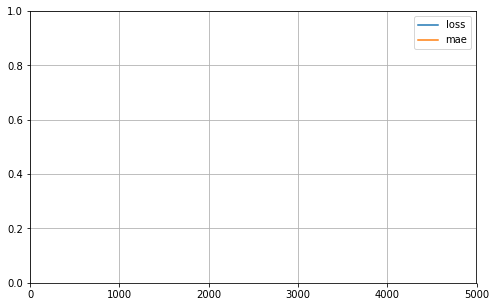

In [18]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [19]:
#Teste = Decoder_model.predict(np.random.randint(-1,1,size = (1,80)))
Teste = model.predict(compasses_array)

In [20]:
Index_musica = 43
A = Teste[Index_musica][0]
B = Teste[Index_musica][1]
C = Teste[Index_musica][2]
D = Teste[Index_musica][3]
E = Teste[Index_musica][4]
F = Teste[Index_musica][5]
G = Teste[Index_musica][6]
H = Teste[Index_musica][7]
I = Teste[Index_musica][8]
J = Teste[Index_musica][9]
Musica_1 = np.concatenate((A,B,C,D,E,F,G,H,I,J),axis=0)
Musica_1_floor = np.floor(Musica_1)
Musica_1_floor = Musica_1_floor
Musica_1_around = np.around(Musica_1)

In [21]:
Write = toPypianoroll(Musica_1_floor, Index_musica, pypianoroll_musics)
Write

(960, 44)
(960, 48)
(960, 36)


Multitrack(tracks=['Guitar'], tempo=array([120., 120., 120., 120., 120., 120., 120., 120., 120., 120.]), downbeat=array([ True, False, False, False, False, False, False, False, False,
       False]), beat_resolution=24, name=bb89cb10224f97d121bdcb3753fdf04a)

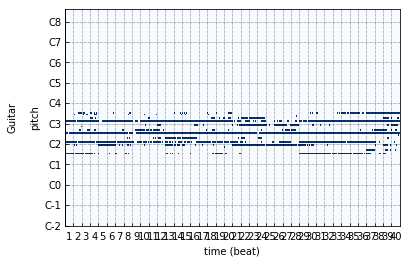

In [22]:
fig = Write.plot()
plt.show()

In [23]:
Musica_1_floor[5]

array([ 0.,  0.,  0.,  0.,  0.,  0., 17.,  0.,  0.,  0.,  0.,  0.,  0.,
        8.,  0.,  0.,  0.,  0., 64.,  0.,  0.,  0.,  0.,  0.,  0., 47.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

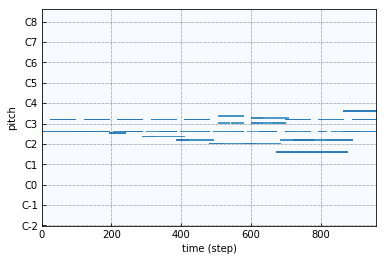

In [24]:
y_test = np.array(Compasses_array)

Real = y_test
A = Real[Index_musica][0]
B = Real[Index_musica][1]
C = Real[Index_musica][2]
D = Real[Index_musica][3]
E = Real[Index_musica][4]
F = Real[Index_musica][5]
G = Real[Index_musica][6]
H = Real[Index_musica][7]
I = Real[Index_musica][8]
J = Real[Index_musica][9]
Musica_2 = np.concatenate((A,B,C,D,E,F,G,H,I,J),axis=0)

track_2 = Track(pianoroll = Musica_2, program=0, is_drum=False,
              name=' ')

fig = track_2.plot()
plt.show()

In [25]:
Write.write('D:\Insper\9o Semestre\Machine Learning\Projeto Musica\Brinca_Second')

In [73]:
Teste = Decoder_model.predict(np.random.randint(-40,60,size = (1,100)))

In [74]:
Index_musica = 0
A = Teste[Index_musica][0]
B = Teste[Index_musica][1]
C = Teste[Index_musica][2]
D = Teste[Index_musica][3]
E = Teste[Index_musica][4]
F = Teste[Index_musica][5]
G = Teste[Index_musica][6]
H = Teste[Index_musica][7]
I = Teste[Index_musica][8]
J = Teste[Index_musica][9]
Musica_1 = np.concatenate((A,B,C,D,E,F,G,H,I,J),axis=0)
Musica_1_floor = np.floor(Musica_1)
Musica_1_floor = Musica_1_floor*4
Musica_1_around = np.around(Musica_1)

In [75]:
Write = toPypianoroll(Musica_1_floor, Index_musica, pypianoroll_musics)
Write

(960, 44)
(960, 48)
(960, 36)


Multitrack(tracks=['Guitar'], tempo=array([122.00180563, 122.00180563, 122.00180563, 122.00180563,
       122.00180563, 122.00180563, 122.00180563, 122.00180563,
       122.00180563, 122.00180563]), downbeat=array([ True, False, False, False, False, False, False, False, False,
       False]), beat_resolution=24, name=b97c529ab9ef783a849b896816001748)

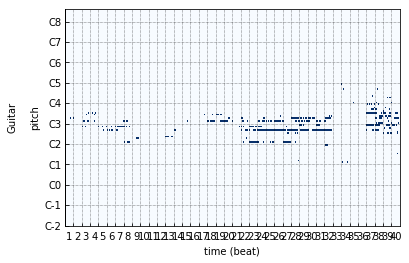

In [76]:
fig = Write.plot()
plt.show()

In [66]:
Write.write('D:\Insper\9o Semestre\Machine Learning\Projeto Musica\Gerações\Gerada5')

In [72]:
model.save('D:\Insper\9o Semestre\Machine Learning\Projeto Musica\Autoencoder.h5')
Decoder_model.save('D:\Insper\9o Semestre\Machine Learning\Projeto Musica\Decoder.h5')
